## import

In [2]:
import numpy as np
import pickle
import pandas as pd
from visualize import *
import seaborn as sns
from utils import *

## dir 

In [2]:
dataset_name = "mnist"
model_name = "LR"
method = 'dpsgdf_bef'
epsilon = 10

subdata_dir = f'../exp/demo_{dataset_name}/{dataset_name}.pkl'
if epsilon > 0:
    exp_dir = f'../exp/demo_{dataset_name}/{model_name}/{method}/eps{epsilon}'
    run_dir = f'../runs/demo_{dataset_name}/{model_name}/{method}/eps{epsilon}'
else:
    exp_dir = f'../exp/demo_{dataset_name}/{model_name}/{method}'
    run_dir = f'../runs/demo_{dataset_name}/{model_name}/{method}'

# log_dir = run_dir
# directories = {
#     "log_dir": log_dir,
#     "report_dir": f"{log_dir}/report",
#     "signal_dir": f"{log_dir}/signals",
#     "data_dir": f"{log_dir}/{dataset_name}.pkl",
#     "model_dir": f"{log_dir}/models",
#     "subdata_dir": subdata_dir,
# }

## load

In [4]:
#load data
path = subdata_dir
with open(path, "rb") as file:
    dataset = pickle.load(file)

path = exp_dir + '/report'
# memberships = np.load(f"{path}/memberships.npy")
# rmia_scores = np.load(f"{path}/rmia_scores.npy")
# load eps
with open(path+'/rmia_eps.pkl', "rb") as file:
    all_eps = pickle.load(file)

# # load norm
# path = run_dir + '/models'
# norm_grad = pd.read_csv(path+"/norm_avg_grad_per_epochs.csv")
# norm_clip_grad = pd.read_csv(path+"/norm_clip_avg_grad_per_epochs.csv")

### eps组间差异大
- 如何可视化差异？ disparate impact/disparate vulnerability
    - 组间均值差异,方差(箱线图)；

- 如何直观地衡量差异？
    1. 组均值之间的标准差 max/min
    2. 不同eps下的比较需要Z-score标准化后比较 max-min
    3. 检验方法：
    - 多组别：单因素方差分析(单因素方差分析(One-Way ANOVA), 用于比较三个或更多组之间的差异)
    - 两组别：t-检验
    - 两个检验需要满足的条件：
        - 正态性：每个组数据应来自正态分布(n<30时需严格满足)。
        - 方差齐性：两个组的方差应相等。
        - 独立性：样本间应独立。

/tmp/ipykernel_319931/94139252.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='group', y='eps', data=data_eps, palette='Blues', showfliers=False) # 去掉异常值，太多异常值了


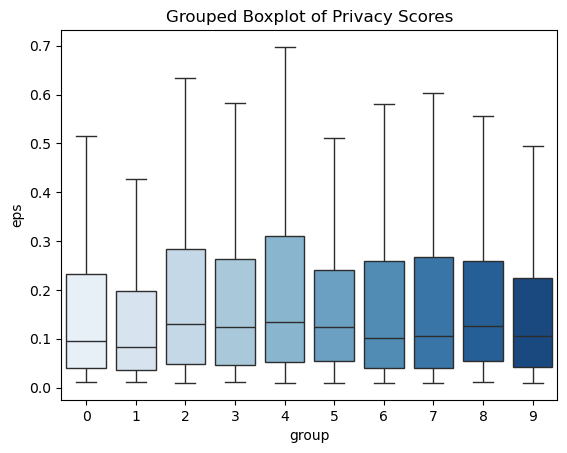

In [23]:
data_eps = {"group":[], "eps":[]}
for i, group_eps in enumerate(all_eps) :
    data_eps['group'] += [i]*len(group_eps)
    data_eps['eps'] += group_eps
data_eps = pd.DataFrame(data_eps)

# 描述性统计
desc_stats = data_eps.groupby('group').eps.describe()
# print(desc_stats)

# 可视化
sns.boxplot(x='group', y='eps', data=data_eps, palette='Blues', showfliers=False) # 去掉异常值，太多异常值了
'''
'Set1'：明亮鲜艳的颜色
'Set2'：柔和的颜色
'Paired'：适合分组对比的颜色
'Blues'、'Greens'、'Reds'：这些是基于不同色系的调色板
'''
plt.title('Grouped Boxplot of Privacy Scores')
plt.show()



In [7]:
def compute_statistical(all_ind_eps):
    group_eps_mean = np.array([np.mean(values) for values in all_ind_eps])
    group_std = np.std(group_eps_mean)
    subtraction = max(group_eps_mean) - min(group_eps_mean)
    division = max(group_eps_mean) / min(group_eps_mean)
    return group_eps_mean, group_std, subtraction, division

compute_statistical(all_eps), compute_statistical(normalize_eps(all_eps))

((array([0.19367239, 0.16409235, 0.19633001, 0.18346797, 0.21151672,
         0.17575814, 0.19485877, 0.19830628, 0.18325835, 0.16108082]),
  0.015052526160631113,
  0.050435898693824005,
  1.313109269992557),
 (array([ 0.03696629, -0.10624024,  0.04983267, -0.01243661,  0.12335646,
         -0.04976237,  0.04270991,  0.05940044, -0.01345144, -0.12082003]),
  0.07287414487130114,
  0.2441764889763791,
  -1.0209934480814526))

In [6]:
import scipy.stats as stats

# 执行单因素方差分析 one-way anova
f_statistic, p_value = stats.f_oneway(*all_eps)
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}") #通过F统计量计算的P值用于判断是否拒绝零假设
# 根据p值判断是否拒绝零假设
alpha = 0.05
if p_value < alpha:
    # 认为至少有一组与其他组有显著差异
    print("There is a significant difference between the groups.")
else:
    print("There is no significant difference between the groups.")

F-statistic: 6.017856589321825
P-value: 1.8604395233065926e-08
There is a significant difference between the groups.


###  adv组间差异 ↔ norm组间差异

In [43]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

model = "MLP"

In [44]:
# load norm
path = f'../runs/demo_mnist_compare/{model}/regular/eps0' + '/models'
norm_grad = pd.read_csv(path+"/norm_avg_grad_per_epochs.csv")
norm_clip_grad = pd.read_csv(path+"/norm_clip_avg_grad_per_epochs.csv")

for i in range(10):
    col = f"norm_clip_avg_grad_{i}"
    norm_clip_grad[col] = norm_clip_grad[col] / norm_clip_grad["norm_clip_avg_grad"]

# 选择除 'norm_avg_grad' 之外的所有列
cols_to_plot = norm_clip_grad.drop(norm_clip_grad.columns[:2], axis=1)
#plot_single_vec(norm_grad['epoch'], cols_to_plot, cols_to_plot.columns.tolist())
norm_mean = cols_to_plot.mean().values
norm_last = cols_to_plot.iloc[-1].values
norm_mean, norm_last

(array([2.19965379, 2.71972134, 4.60759309, 5.37973908, 4.58388406,
        5.98764981, 3.17614855, 3.87025027, 6.1762652 , 5.88781638]),
 array([1.57981028, 2.26020353, 3.88156371, 4.86513576, 3.98062688,
        5.03705077, 2.61474088, 3.57844585, 5.15198051, 5.42583605]))

In [45]:
path = f'../exp/demo_mnist/{model}/regular/eps0' + '/report'
with open(path+'/loss_acc.pkl', "rb") as file:
    all_acc = pickle.load(file)
all_adv_acc = [[2*value-1 for value in group] for group in all_acc]
group_adv_mean = np.array([np.mean(values) for values in all_adv_acc])
print(group_adv_mean)
print(max(group_adv_mean) - min(group_adv_mean))

[0.13727  0.113635 0.217425 0.212625 0.189195 0.255715 0.161975 0.171815
 0.2519   0.218645]
0.14208000000000004


In [46]:
corr, _ = pearsonr(group_adv_mean, norm_mean)
# 两个向量强相关 线性关系 一个增加导致另一个增加
print(f"Pearson Correlation Coefficient: {corr}")

# 计算斯皮尔曼等级相关系数 表示两个数组的排名高度一致
corr, _ = spearmanr(group_adv_mean, norm_mean)
print(f"斯皮尔曼等级相关系数: {corr}")

# 计算肯德尔等级相关系数
corr, _ = kendalltau(group_adv_mean, norm_mean)
print(f"肯德尔等级相关系数: {corr}")

# 对A和B进行排名
rank_A = np.argsort(norm_mean) 
rank_B = np.argsort(group_adv_mean) 
print(f"A数组的排名: {rank_A}")
print(f"B数组的排名: {rank_B}")

Pearson Correlation Coefficient: 0.9461404042848985
斯皮尔曼等级相关系数: 0.9636363636363635
肯德尔等级相关系数: 0.8666666666666666
A数组的排名: [0 1 6 7 4 2 3 9 5 8]
B数组的排名: [1 0 6 7 4 3 2 9 8 5]


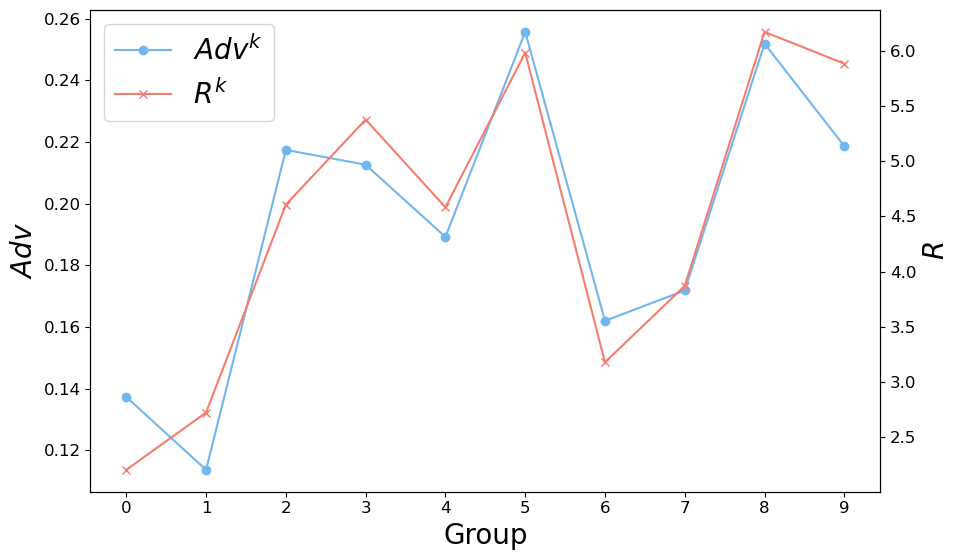

In [47]:
groups = np.arange(10)

# 全局字体大小设置
plt.rcParams.update({
    "font.size": 20,      # 默认字体大小
    "axes.labelsize": 20, # 坐标轴标签字体大小
    "xtick.labelsize": 12, # x轴刻度字体大小
    "ytick.labelsize": 12  # y轴刻度字体大小
})

# 创建一个图形
fig, ax1 = plt.subplots(figsize=(10, 6))

# 绘制第一个 y 轴的直方图（group_eps_mean）
# ax1.bar(groups, group_adv_mean, color='#84c3b7', alpha=0.8, label='group_adv_mean')
ax1.plot(groups, group_adv_mean, color='#71b7ed', marker='o', label=r'$Adv^k$')
ax1.set_xlabel('Group')
ax1.set_ylabel(r'$Adv$')
ax1.tick_params(axis='y')

# 创建第二个 y 轴
ax2 = ax1.twinx()

# 绘制第二个 y 轴的折线图（group_norm_mean）
ax2.plot(groups, norm_mean, color='#f57c6e', marker='x', label=r'$R^k$')
ax2.set_ylabel(r'$R$')
ax2.tick_params(axis='y')

# 合并两个坐标轴的图例，并设置位置
lines = ax1.get_lines() + ax2.get_lines()
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels)

# 设置标题
# plt.title('Group-wise Analysis: eps_mean and norm_mean')
plt.xticks(groups)
# plt.legend()
plt.tight_layout()
#plt.show()
path = "../runs/demo_mnist_compare/figs/" + f"{model}.pdf"
plt.savefig(path, dpi=400, bbox_inches='tight')


### disparate impact/disparate vulnerability减小
#### group_norm

In [ ]:
import pandas as pd
path =  '../runs/demo_mnist/'
# load norm
norm_clip_grad_regular = pd.read_csv(path + 'CNN/regular/eps0/models'+"/norm_clip_avg_grad_per_epochs.csv")
# norm_clip_grad_regular = pd.read_csv(path + 'CNN/regular/eps0/models'+"/avg_grad_norms_per_epochs.csv")
norm_clip_grad_dpsgd = pd.read_csv(path + 'CNN/regular/eps0/models'+"/norm_clip_avg_grad_per_epochs.csv")
norm_clip_grad_dpsgdf = pd.read_csv(path + 'CNN/regular/eps0/models'+"/norm_clip_avg_grad_per_epochs.csv")
norm_clip_grad_dpsgdga = pd.read_csv(path + 'CNN/regular/eps0/models'+"/norm_clip_avg_grad_per_epochs.csv")
norm_clip_grad_dpsgdfga = pd.read_csv(path + 'CNN/regular/eps0/models'+"/norm_clip_avg_grad_per_epochs.csv")

In [23]:
def compute_norm_mean(norm_clip_grad):
    # 选择除 'norm_avg_grad' 之外的所有列
    cols_to_plot = norm_clip_grad.drop(norm_clip_grad.columns[:2], axis=1)
    #plot_single_vec(norm_grad['epoch'], cols_to_plot, cols_to_plot.columns.tolist())
    norm_mean = cols_to_plot.mean().values
    return norm_mean

norm_mean_regular = compute_norm_mean(norm_clip_grad_regular)
norm_mean_dpsgd = compute_norm_mean(norm_clip_grad_dpsgd)
norm_mean_dpsgdf = compute_norm_mean(norm_clip_grad_dpsgdf)
# norm_mean_dpsgdg = compute_norm_mean(norm_clip_grad_dpsgdg)
norm_mean_dpsgdga = compute_norm_mean(norm_clip_grad_dpsgdga)
norm_mean_dpsgdfga = compute_norm_mean(norm_clip_grad_dpsgdfga)
# print(norm_mean_regular, norm_mean_dpsgd, norm_mean_dpsgdf)

# print(np.std(norm_mean_regular), np.std(norm_mean_dpsgd), np.std(norm_mean_dpsgdf))
# print(max(norm_mean_regular) / min(norm_mean_regular), max(norm_mean_dpsgd) / min(norm_mean_dpsgd), max(norm_mean_dpsgdf) / min(norm_mean_dpsgdf))
def print_norm_statistical(norm_mean, method):
    # 使用f-string进行格式化，并确保每列宽度一致
    norm_std = np.std(norm_mean)
    max_sub_min = max(norm_mean) - min(norm_mean)
    max_min_ratio = max(norm_mean) / min(norm_mean)
    print(f"{method:<10}\t{norm_std:<10.4f}\t{max_sub_min:<15.4f}\t{max_min_ratio:<15.4f}")

print(f"{'method':<10}\t{'norm_std':<10}\t{'max-min':<15}\t{'max/min':<15}")
print_norm_statistical(norm_mean_regular, "regular")
print_norm_statistical(norm_mean_dpsgd, "dpsgd")
print_norm_statistical(norm_mean_dpsgdf, "dpsgdf")
# print_norm_statistical(norm_mean_dpsgdg, "dpsgdg")
print_norm_statistical(norm_mean_dpsgdga, "dpsgdga")
print_norm_statistical(norm_mean_dpsgdfga, "dpsgdfga")


method    	norm_std  	max-min        	max/min        
regular   	0.0307    	0.0614         	1.4893         
dpsgd     	0.0069    	0.0137         	1.6722         
dpsgdf    	0.0038    	0.0075         	1.3656         
dpsgdga   	0.0048    	0.0096         	1.5645         
dpsgdfga  	0.0010    	0.0021         	1.1224         


#### group eps

In [ ]:
def rea_eps(path):
    with open(path+'/rmia_eps.pkl', "rb") as file:
        all_eps = pickle.load(file)
    return all_eps

path = '../exp/demo_mnist/'
eps_regular = rea_eps(path + 'LR/regular/report')
eps_dpsgd = rea_eps(path + 'LR/dpsgd/eps10/report')
eps_dpsgdf = rea_eps(path + 'LR/dpsgdf/eps10/report')
eps_dpsgdg = rea_eps(path + 'LR/dpsgdg/eps10/report')
eps_dpsgdga = rea_eps(path + 'LR/dpsgdga/eps10/report')
#eps_dpsgdfg = rea_eps('../exp/demo_mnist/LR/dpsgdfg/eps10/report')

def compute_statistical(all_ind_eps, method):
    group_eps_mean = np.array([np.mean(values) for values in all_ind_eps])
    group_std = np.std(group_eps_mean)
    max_sub_min = max(group_eps_mean) - min(group_eps_mean)
    max_div_min = max(group_eps_mean) / min(group_eps_mean)
    print(f"{method:<10}\t{group_std:<10.4f}\t{max_sub_min:<15.4f}\t{max_div_min:<15.4f}")
    #return group_eps_mean, group_std, subtraction, division


print(f"{'method':<10}\t{'eps_std':<10}\t{'max-min':<15}\t{'max/min':<15}")
compute_statistical(eps_regular, "regular")
compute_statistical(eps_dpsgd, "dpsgd")
compute_statistical(eps_dpsgdf, "dpsgdf")
compute_statistical(eps_dpsgdg, "dpsgdg")
compute_statistical(eps_dpsgdga, "dpsgdga")
#print_norm_statistical(eps_dpsgdfg, "dpsgdfg")

method    	eps_std   	max-min        	max/min        
regular   	0.1511    	0.5099         	2.7744         
dpsgd     	0.0522    	0.1840         	1.9947         
dpsgdf    	0.0151    	0.0504         	1.3131         
dpsgdg    	0.0237    	0.0769         	1.5169         
dpsgdga   	0.0427    	0.1514         	1.9230         


### group acc

In [40]:
path = '../runs/demo_mnist/'
all_acc_regular = pd.read_csv(path + 'LR/regular/eps0/models' + "/train_acc_per_epochs.csv")
all_acc_dpsgd = pd.read_csv(path + 'LR/dpsgd/eps10/models'+"/train_acc_per_epochs.csv")
all_acc_dpsgdf = pd.read_csv(path + 'LR/dpsgdf/eps10/models'+"/train_acc_per_epochs.csv")
# all_acc_dpsgdg = pd.read_csv('../runs/demo_mnist/LR/dpsgdg/eps10/models'+"/train_acc_per_epochs.csv")
all_acc_dpsgdga = pd.read_csv(path + 'LR/dpsgdga/eps10/models'+"/train_acc_per_epochs.csv")
# all_acc_dpsgdfg = pd.read_csv('../runs/demo_mnist/LR/dpsgdfg/eps10/models'+"/train_acc_per_epochs.csv")
# all_acc_dpsgdfga = pd.read_csv(path + 'LR/dpsgdfga/eps10/models'+"/train_acc_per_epochs.csv")

def get_last_epoch(acc):
    cols_to_plot = acc.drop(acc.columns[:1], axis=1)
    acc = cols_to_plot.iloc[-1].values
    return acc

def print_acc(method, acc):
    info = method + "   \t" + "\t".join([f"{i:.4f}" for i in acc])
    print(info)

num_groups = 10
header = "method  \t" + "all\t" + "\t".join([f"group{i}" for i in range(num_groups)])
print(header)
print_acc("regular", get_last_epoch(all_acc_regular))
print_acc("dpsgd", get_last_epoch(all_acc_dpsgd))
print_acc("dpsgdf", get_last_epoch(all_acc_dpsgdf))
# print_acc("dpsgdg", get_last_epoch(all_acc_dpsgdg))
print_acc("dpsgdga", get_last_epoch(all_acc_dpsgdga))
# print_acc("dpsgdfg", get_last_epoch(all_acc_dpsgdfg))
# print_acc("dpsgdfga", get_last_epoch(all_acc_dpsgdfga))


method  	all	group0	group1	group2	group3	group4	group5	group6	group7	group8	group9
regular   	0.9375	0.9805	0.9718	0.9196	0.9192	0.9355	0.8938	0.9605	0.9528	0.9095	0.9232
dpsgd   	0.9226	0.9740	0.9673	0.8986	0.8994	0.9324	0.8738	0.9598	0.9287	0.8871	0.8999
dpsgdf   	0.9192	0.9770	0.9708	0.8933	0.8966	0.9283	0.8574	0.9628	0.9227	0.8700	0.9103
dpsgdga   	0.9218	0.9674	0.9674	0.9071	0.8971	0.9353	0.8811	0.9550	0.9326	0.8904	0.9027


### data class size

In [43]:
# dataset[0][0]:feature; dataset[0][1]:class label
class_size = {i:0 for i in range(10)}

for features, label in dataset:
    class_size[label] += 1

print(class_size)


{0: 987, 1: 1126, 2: 999, 3: 1021, 4: 975, 5: 902, 6: 983, 7: 1042, 8: 975, 9: 994}


### estimated eps

In [17]:
#每一类的平均
for i in range(10):
    print(f"{i}:{np.mean(all_eps[i])}, {np.std(all_eps[i])}")

0:0.5823493699151622, 0.5157638806047562
1:0.445257598873508, 0.37970958110289965
2:0.7205007116709642, 0.5424871663374657
3:0.7059799149439315, 0.5260698684906554
4:0.6542791346714212, 0.479369923966628
5:0.7946106737536321, 0.5274959473416806
6:0.607483049749318, 0.5088517627120771
7:0.5883977801255004, 0.4770889981798912
8:0.799060839252443, 0.5412753834513692
9:0.6972484110733957, 0.47601429706103954


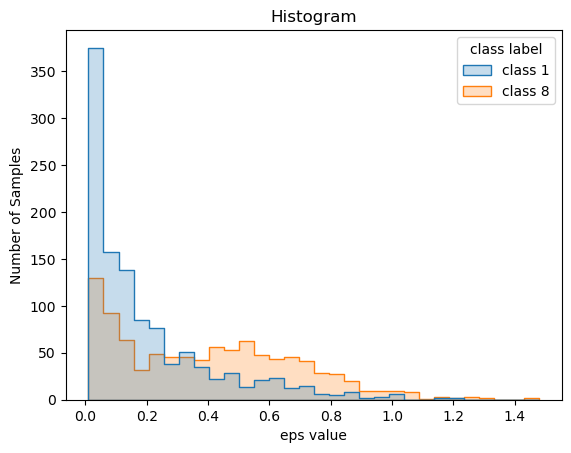

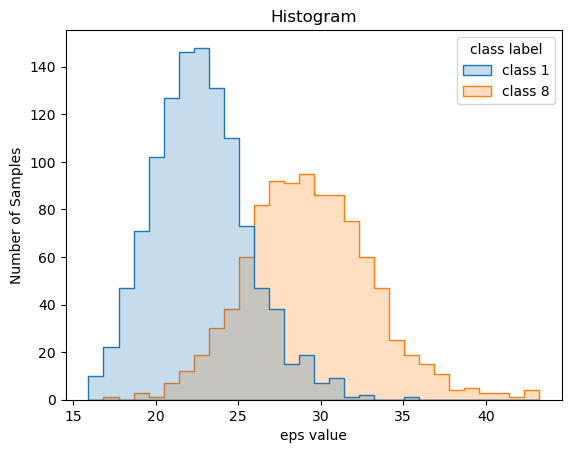

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_signals(data_dict, threshold=None, base_path=None, save=False, show=False):
    # 将字典转换为数据框
    data_list = []
    for class_label, eps_values in data_dict.items():
        if class_label == 1 or class_label == 8:
            for eps in eps_values:
                data_list.append({"eps": eps, "class label": f"class {class_label}"})
    data = pd.DataFrame(data_list)
    
    # 设置绘图风格
    # sns.set(style="whitegrid")

    #plt.figure(figsize=(10, 6))
    histogram = sns.histplot(
        data=data,
        x="eps",
        hue="class label",
        element="step",
        bins=30
        # stat="density",
        # kde=True,
    )

    # # 添加阈值线（如果设置了阈值）
    # if threshold is not None:
    #     plt.axvline(x=threshold, linestyle="--", color="red")
    #     plt.text(
    #         x=threshold,
    #         y=plt.gca().get_ylim()[1] * 0.8,
    #         s="Threshold",
    #         rotation=90,
    #         color="red"
    #     )

    plt.title("Histogram")
    plt.xlabel("eps value")
    plt.ylabel("Number of Samples")
    #plt.grid()
    if save and base_path:
        filename = f"{base_path}/signal_histogram.jpg"
        plt.tight_layout()
        plt.savefig(fname=filename, dpi=400)
    if show:
        plt.show()
    plt.close()

plot_signals(all_eps, base_path="path", save=False, show=True)
plot_signals(all_input_norm, base_path="path", save=False, show=True)


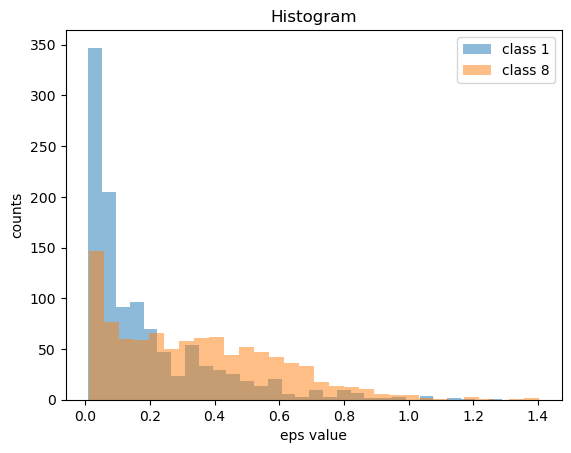

In [44]:
import matplotlib.pyplot as plt

def draw_hist(data_dict):
    # 创建一个图形和子图
    fig, ax = plt.subplots()

    # 为每个类别绘制直方图
    for label, values in data_dict.items():
        if label == 1 or label == 8:
            # bins: 直方图的柱数（或区间数）
            # alpha: 图形元素的透明度
            ax.hist(values, bins=30, alpha=0.5, label=f'class {label}')

    # 添加标题和标签
    ax.set_title('Histogram')
    ax.set_xlabel('eps value')
    ax.set_ylabel('counts')
    ax.legend()

    # 显示图形
    plt.show()

draw_hist(all_eps)
#draw_hist(all_input_norm)


### data class input_norm

In [8]:
# dataset[0][0]:feature; dataset[0][1]:class label
all_input_norm = {i:[] for i in range(10)}

for features, label in dataset:
    # 计算 L2 范数 (input_norm)
    input_norm = np.linalg.norm(features)
    all_input_norm[label].append(input_norm)

for i in range(10):
    print(f"{i}:{np.mean(all_input_norm[i])}")

0:31.479246139526367
1:22.681251525878906
2:29.321821212768555
3:28.56865692138672
4:26.94462013244629
5:27.376888275146484
6:28.49887466430664
7:26.396617889404297
8:29.335590362548828
9:26.871002197265625


### class loss

In [29]:
len(dataset)

10004